# *Gesture Recognition Case Study*

Recognising 5 different hand gestures to control a smart TV

We need to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Thumbs up: Increase the volume

Thumbs down: Decrease the volume

Left swipe: 'Jump' backwards 10 seconds

Right swipe: 'Jump' forward 10 seconds

Stop: Pause the movie

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

In [1]:
#importing the libraries
import numpy as np
import os
import datetime
import os
import imageio
from skimage.io import imread, imshow
from skimage.transform import resize # Using skimage instead of scipy.misc

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
import keras as Keras
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
#dataset
link = 'https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL'

In [5]:
#Import the libraries to extract all the data from zip file
import zipfile 
import os 
#Opens the zip file in read mode 
#Extracts the files into the /tmp folder 
zip_ref.close()

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 51

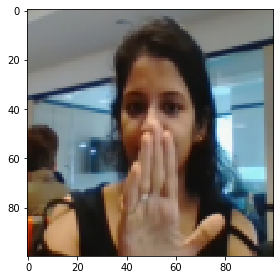

In [7]:
import glob
img = imread(glob.glob(os.path.join("Project_data/train/", train_doc[162].split(';')[0], '*'))[15])
h = img.shape[0]
imshow(resize(img[75:-75, 50:-50, :], (100,100,3)))

***Generator***

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(source_path)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    
                    
                    # Cropped image of above dimension 
                    # (It will not change orginal image) 
                    
                    #image = image.crop((0, 0, 120, 120))
                    image = image.resize(100, 100)
                    
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] /= 255
                    batch_data[folder,idx,:,:,1] /= 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] /= 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if((len(source_path)%batch_size)//2==0):
            batch_size = 2
        else:
            batch_size = 1
        num_batches = len(source_path)%batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    
                    
                    # Cropped image of above dimension 
                    # (It will not change orginal image) 
                    
                    #image = image.crop((0, 0, 120, 120))
                    image = image.resize(100, 100)
                    
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] /= 255
                    batch_data[folder,idx,:,:,1] /= 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] /= 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [28]:
curr_dt_time = datetime.datetime.now()
train_path = 'drive/My Drive/tmp/Project_data/train'
val_path = 'drive/My Drive/tmp/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


***Model***

Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Experiment - 1 & 2
Conv3D Baseline model

In [33]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=Input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [34]:
optimiser = Keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 98, 98, 32)    2624      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 8, 49, 49, 32)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 6, 47, 47, 64)     55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 3, 23, 23, 64)    0         
 3D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 101568)            0         
                                                                 
 dense_3 (Dense)             (None, 256)              

In [38]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 1.6103 - categorical_accuracy: 0.0385    
Epoch 1: saving model to Gesture_recog_2023-05-2909_46_25.395716\model-00001-1.61034-0.03846-1.60847-0.50000.h5
13/13 [==============================] - 12s 860ms/step - loss: 1.6103 - categorical_accuracy: 0.0385 - val_loss: 1.6085 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 1.6085 - categorical_accuracy: 0.3462
Epoch 2: saving model to Gesture_recog_2023-05-2909_46_25.395716\model-00002-1.60846-0.34615-1.61245-0.00000.h5
13/13 [==============================] - 11s 818ms/step - loss: 1.6085 - categorical_accuracy: 0.3462 - val_loss: 1.6124 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 1.6103 - categorical_accuracy: 0.1923
Epoch 3: saving model to Gesture_recog_2023-05-2909_46_25.395716\model-00003-1.61027-0.19231-1.61001-0.00000.h5


### Conv3D ###

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
Input_shape = (18, 100, 100, 3)
model = Sequential()
model.add(Conv3D(32, (3,3,3), padding='same',
                 input_shape=Input_shape))
#model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(32, (3, 3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.5))

model.add(Conv3D(64, (3, 3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(64, (3, 3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser = Keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 32)  2624      
                                                                 
 activation (Activation)     (None, 18, 100, 100, 32)  0         
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 32)  128      
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 98, 98, 32)    27680     
                                                                 
 activation_1 (Activation)   (None, 16, 98, 98, 32)    0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 98, 98, 32)   128       
 hNormalization)                                        

Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [12]:
train_generator = generator(train_path,train_doc,batch_size=32)
val_generator = generator(val_path, val_doc, batch_size=32)

In [13]:
model_name = 'Gesture_recog' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
       
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')


LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", min_delta = 1e-04, cooldown = 0,
  min_learning_rate = 0)
callbacks_list = [checkpoint, LR]

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  drive/My Drive/tmp/Project_data/train ; batch size = 32
Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.1136Source path =  drive/My Drive/tmp/Project_data/val ; batch size = 32

Epoch 1: saving model to Gesture_recog_2023-05-2909_46_25.395716\model-00001-1.60940-0.11364-1.60966-0.18182.h5
13/13 [==============================] - 69s 2s/step - loss: 1.6094 - categorical_accuracy: 0.1136 - val_loss: 1.6097 - val_categorical_accuracy: 0.1818 - lr: 0.0010
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 1.6086 - categorical_accuracy: 0.2308
Epoch 2: saving model to Gesture_recog_2023-05-2909_46_25.395716\model-00002-1.60865-0.23077-1.60389-0.50000.h5
13/13 [==============================] - 16s 1s/step - loss: 1.6086 - categorical_accuracy: 0.2308 - val_loss: 1.6039 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 1.6102 - categorical_acc

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


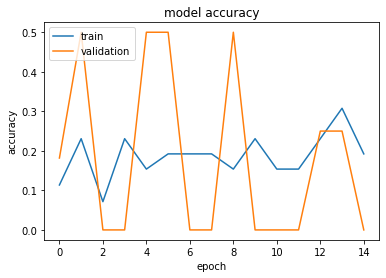

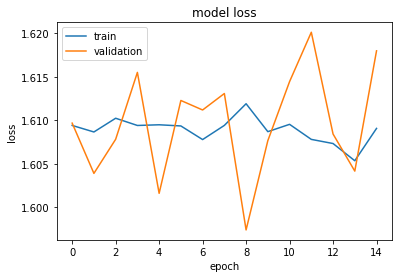

In [37]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Model CONV2D + LSTM**

In [16]:
#write your model here
from keras.models import Sequential, Model
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional


Input_shape_1 = (18, 100, 100, 3)
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=Input_shape_1))
model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
 
model.add(TimeDistributed(Flatten()))
 
model.add(Dropout(0.5))
model.add(LSTM(512, return_sequences=False, dropout=0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 50, 50, 32)   4736      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 48, 48, 32)   9248      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 24, 24, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 24, 24, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 24, 24, 64)  

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [17]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 50, 50, 32)   4736      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 48, 48, 32)   9248      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 24, 24, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 24, 24, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 24, 24, 64)  

Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
model_name = 'Gesture_recog' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", min_delta = 1e-04, cooldown = 0,
  min_lr = 0)
callbacks_list = [checkpoint, LR]

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [21]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  drive/My Drive/tmp/Project_data/train ; batch size = 51
Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 1.5956 - categorical_accuracy: 0.2308Source path =  drive/My Drive/tmp/Project_data/val ; batch size = 51

Epoch 1: saving model to Gesture_recog_2023-05-2909_46_25.395716\model-00001-1.59556-0.23077-1.62214-0.00000.h5
13/13 [==============================] - 9s 415ms/step - loss: 1.5956 - categorical_accuracy: 0.2308 - val_loss: 1.6221 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 1.6189 - categorical_accuracy: 0.2308
Epoch 2: saving model to Gesture_recog_2023-05-2909_46_25.395716\model-00002-1.61892-0.23077-1.67165-0.00000.h5
13/13 [==============================] - 5s 378ms/step - loss: 1.6189 - categorical_accuracy: 0.2308 - val_loss: 1.6717 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 1.6172 - cat

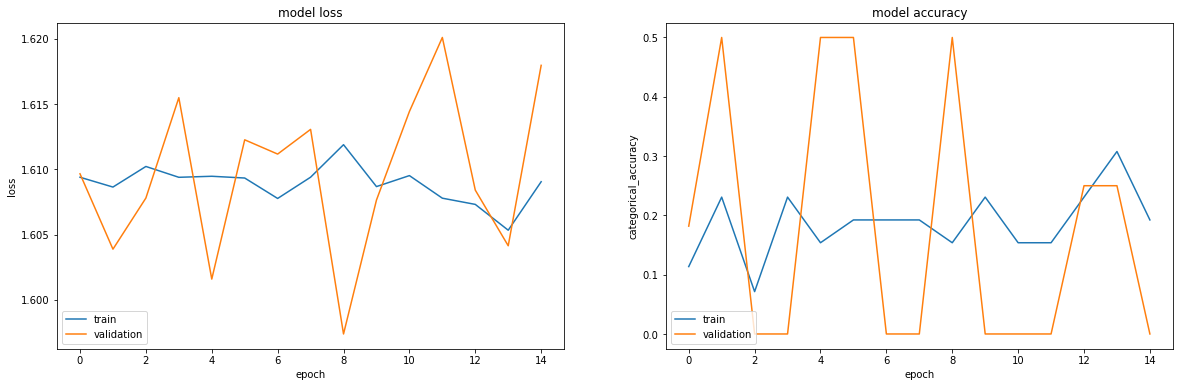

In [31]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')